# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import random

# Functions

## Fungsi Konstanta

In [2]:
def func_alpha(size):
    if size >= 1000000:
        return 0

    c = 0.0000001
    m = -0.0000001/1000000

    res = c + m*size

    return res


def func_beta(size):
    c = 0
    m = 20

    res = c + m*size

    return res


def func_gamma(size):
    c = 0
    m = 50

    res = c + m*size

    return res

## Kelas dan Fungsi dari Pemain dan Permainan

In [3]:
class Player:
    """
    A class to represent a player.

    ...

    Attributes
    ----------
    size : int
        the size that indicates how much followers/subscriber the player currently has.
        
    lr : list of float
        list of likes/views ratio of the 5 latest contents.
        
    cr : list of float
        list of comments/views ratios of the 5 latest contents.
        
    lr_avg : float
        the weighted average of lr.
    
    cr_avg: float
        the weighted average of cr.
        
    action : int
        other player (partner) that this player choose to collaborate.
        
    payoff_ : 2D list of float
        list of the player's payoff at every time period.
        for example, payoff_[i] would be the player's payoff at the time t = i.
        the payoff at each period is a list consists of n-1 elements, where n is the number of player.
    
    actions : list of int
        list of the player's partner at every time period.
    
    sizes : list of int
        list of the player's size at every time period.
    
    

    Methods
    -------
    update_ratio():
        Updates the lr_avg and cr_avg attributes as lr and cr updated (because new content is being made).
    """

    def __init__(self, size, lr, cr):
        """
        Constructs all the necessary attributes for the player object.

        Parameters
        ----------
            size : int
                the size that indicates how much followers/subscriber the player currently has.
        
            lr : list of float
                list of likes/views ratio of the 5 latest contents.

            cr : list of float
                list of comments/views ratios of the 5 latest contents.
        """
        
        self.size = size
        self.lr = lr.copy()
        self.cr = cr.copy()
        self.action = 0
        self.payoff_ = []
        self.actions = []
        self.sizes = []
        self.lr_avgs = []
        self.cr_avgs = []
        
        self.update_ratio()
    
    def update_ratio(self):
        """
        Updates the lr_avg and cr_avg attributes as lr and cr updated (because new content is being made).

        Returns
        -------
        None
        """
        
        w = [0.11, 0.11, 0.26, 0.26, 0.26]
        self.lr_avg = np.average(self.lr, weights=w)
        self.cr_avg = np.average(self.cr, weights=w)
        self.lr_avgs.append(self.lr_avg)
        self.cr_avgs.append(self.cr_avg)


class Game:
    """
    A class to represent the game.

    ...

    Attributes
    ----------
    players : list of Player
        list of every players that participate in this game.
    
    payoffs : 2D list of float
        list of every player's payoff, which each player's payoff is a list itself.
    
    actions : 2D list of int
        list of the number of collaboration done by two players.
        
    t : int
        denotes how many time the game will be played.

    Methods
    -------
    _payoff_(p1, p2):
        returns the payoff value of player p1 against player p2.
        
    update_payoff():
        updates the attribute payoffs so that payoffs[i][j] is the payoff of player i against player j.
    
    choose_phase():
        updates each player's attribute (action and actions).
        
    update_phase():
        updates each player's attribute (size, sizes, lr, cr, lr_avg, cr_avg).
        
    plot_size():
        plots each player's size over time using line plot.
    
    plot_payoff(t=-1):
        plots each player's payoff at the time t using heatmap.
    
    plot_action():
        plots how many times each player collaborated with another player using heatmap.
    
    play(t):
        plays the game with t times repetition of choose_phase() and update_phase().
        
    """
    t = 0

    def __init__(self, size, like, comment):
        """
        Constructs players and payoffs attribute.

        Parameters
        ----------
            size : list of int
                list of each player's size, so that size[i] indicates player i's size
        
            like : 2D list of float
                list of each player's likes/views ratio (of 5 latest contents)

            comment : 2D list of float
                list of each player's likes/views ratio (of 5 latest contents)
            
            actions : 2D list of int
                list of the number of collaboration done by two players.
                for example, actions[0][1] indicates how many collaboration done by player 0 and player 1.
                note that the matrix is simmetrical, meaning actions[i][j] == actions[j][i]
        """
        self.players = [Player(size[i], like[i], comment[i]) for i in range(n)]
        self.payoffs = [[0 for i in range(n)] for i in range(n)]
        self.actions = [[0 for i in range(n)] for i in range(n)]

    def _payoff_(self, p1, p2):
        """
        returns the payoff value of player p1 against player p2.

        Parameters
        ----------
            p1, p2 : int
                indicates the index of the two players
        
        Returns
        -------
            u_ij : float
                the payoff value between p1 and p2
        """

        alpha = func_alpha(p1.size)
        beta = func_beta(p1.size)
        gamma = func_gamma(p1.size)

        u_ij = np.sqrt(alpha*((p1.size - p2.size)**2) + beta*(p2.lr_avg)**2 + gamma*(p2.cr_avg)**2)
        return u_ij

    def update_payoff(self):
        """
        updates the attribute payoffs so that payoffs[i][j] is the payoff of player i against player j.
        """
        
        for i in range(n):
            pi = self.players[i]
            for j in range(n):
                if i != j:
                    pj = self.players[j]
                    self.payoffs[i][j] = self._payoff_(pi, pj)
            pi.payoff_.append(self.payoffs[i].copy())

    def choose_phase(self):
        """
        updates each player's attribute (action and actions).
        """
        
        self.update_payoff()
        for i in range(n):
            pi = self.players[i]
            pi.action = self.payoffs[i].index(max(self.payoffs[i]))
            pi.actions.append(pi.action)
            
            j = pi.action
            self.actions[i][j] += 1
            self.actions[j][i] += 1

    def update_phase(self):
        """
        updates each player's attribute (size, sizes, lr, cr, lr_avg, cr_avg).
        """
        
        size_ = [0 for i in range(n)]

        for i in range(n):
            pi = self.players[i]
            j = pi.action

            u_i = self.payoffs[i][j]
            u_j = self.payoffs[j][i]
            
            # mencegah overflow
            size[i] += random.uniform(1e-9, 1e-8)

            size_[i] += u_i * np.log(abs(size[i] - size[j]))
            size_[j] += u_j * np.log(abs(size[i] - size[j]))
            
        for i in range(n):
            pi = self.players[i]
            
            lr_modif = pi.lr_avg - self.players[pi.action].lr_avg
            cr_modif = pi.cr_avg - self.players[pi.action].cr_avg
            
            random_lr = random.uniform(-0.1, 0.1) * lr_modif
            random_cr = random.uniform(-0.1, 0.1) * cr_modif
            
            
            for k in range(4):
                pi.lr[k] = pi.lr[k+1]
                pi.cr[k] = pi.cr[k+1]
                
            pi.lr[-1] = pi.lr[-2] + random_lr
            pi.cr[-1] = pi.cr[-2] + random_cr
            
            if pi.lr[-1] > 1:
                pi.lr[-1] = 1
            elif pi.lr[-1] < 0:
                pi.lr[-1] = 0
                
            if pi.cr[-1] > 1:
                pi.cr[-1] = 1
            elif pi.cr[-1] < 0:
                pi.cr[-1] = 0
            
            pi.update_ratio()

        for i in range(n):
            pi = self.players[i]
            pi.size += round(size_[i], 0)
            pi.sizes.append(pi.size)
            

    def plot_size(self):
        """
        plots each player's size over time using line plot.
        """
        plt.figure(figsize=(12, 6))
        for i, p in enumerate(game.players):
            sns.lineplot(x=[i for i in range(len(p.sizes))],
                         y=p.sizes, label=i+1)
        plt.xlabel('waktu', fontsize=16)
        plt.ylabel('ukuran', fontsize=16)
        plt.legend()
        plt.show()
        
    def plot_lr(self):
        """## Nilai Awal
        plots each player's likes/views ratio average over time using line plot.
        """
        plt.figure(figsize=(12, 6))
        for i, p in enumerate(game.players):
            sns.lineplot(x=[i for i in range(len(p.lr_avgs))],
                         y=p.lr_avgs, label=i+1)
        plt.xlabel('waktu', fontsize=16)
        plt.ylabel('rerata rasio suka', fontsize=16)
        plt.legend()
        plt.show()
    
    def plot_cr(self):
        """
        plots each player's comments/views ratio average over time using line plot.
        """
        plt.figure(figsize=(12, 6))
        for i, p in enumerate(game.players):
            sns.lineplot(x=[i for i in range(len(p.cr_avgs))],
                         y=p.cr_avgs, label=i+1)
        plt.xlabel('waktu', fontsize=16)
        plt.ylabel('rerata rasio komentar', fontsize=16)
        plt.legend()
        plt.show()

    def plot_payoff(self, t=-1):
        """
        plots each player's payoff at the time t using heatmap.
        """
        payoff_t = []
        for p in game.players:
            payoff_t.append(p.payoff_[t])

        plt.figure(figsize=(12, 6))
        sns.heatmap(payoff_t, annot=True, fmt='g',
                    cmap=sns.light_palette("seagreen", as_cmap=True))
        plt.show()
        
    def plot_action(self):
        """
        plots how many times each player collaborated with another player using heatmap.
        """
        action_count = [[0 for i in range(n)] for i in range(n)]
        
        for i in range(n):
            pi = self.players[i]
            for k in range(self.t):
                action_count[i][pi.actions[k]] += 1
                
        plt.figure(figsize=(12, 6))
        
        labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        df_cm = pd.DataFrame(self.actions, index = labels,
                  columns = labels)
        
        sns.heatmap(df_cm, annot=True, fmt='d',
                    cmap=sns.light_palette("seagreen", as_cmap=True),
                    mask=np.triu(np.ones_like(self.actions)))
        plt.show()

    def play(self, t):
        """
        plays the game with t times repetition of choose_phase() and update_phase().
        
        Parameters
        ----------
            t : int
                indicates how many times the game will be played
        """
        self.t = t
        for i in range(t):
            self.choose_phase()
            self.update_phase()

## Nilai Awal

In [4]:
n = 10
size = [1000, 10000, 50000, 100000, 200000,
        300000, 500000, 750000, 1000000, 2000000]

like = [[0.0368, 0.0289, 0.0346, 0.0225, 0.031],
        [0.0141, 0.0126, 0.0083, 0.0456, 0.0135],
        [0.0308, 0.0387, 0.0541, -0.0026, 0.0075],
        [0.0431, 0.0424, 0.0083, -0.0055, -0.0021],
        [0.0116, 0.0262, 0.0165, -0.002, 0.0149],
        [-0.0096, 0.0028, 0.0232, 0.017, 0.0151],
        [0.0081, -0.0373, 0.015, 0.0191, 0.0056],
        [0.0164, 0.0115, 0.0328, 0.0053, 0.019],
        [0.0032, 0.0289, 0.0227, -0.0074, 0.0215],
        [0.0344, 0.0269, 0.007, 0.0198, -0.0002]]

comment = [[0.0005, 0.0017, 0.0008, 0.0014, 0.0019],
           [0.0005, 0.0007, 0.0012, 0.0005, 0.0015],
           [0.0016, 0.0014, 0.0007, 0.0008, 0.0011],
           [0.0009, 0.0008, -0.0003, 0.0005, 0.0012],
           [0.0007, 0.0012, 0.0016, 0.0009, 0.0014],
           [0.0012, 0.0013, 0.0006, 0.0012, 0.0005],
           [0.0018, 0.001, 0.0016, 0.001, 0.0011],
           [0.0005, 0.0007, 0.0007, 0.0009, 0.0023],
           [0.0012, 0.0007, 0.0003, 0.001, 0.0006],
           [0.0016, 0.0002, 0.001, 0.0011, -0.0005]]

# seed agar kodenya reproducible
random.seed(5)

In [5]:
game = Game(size, like, comment)

game.play(300)

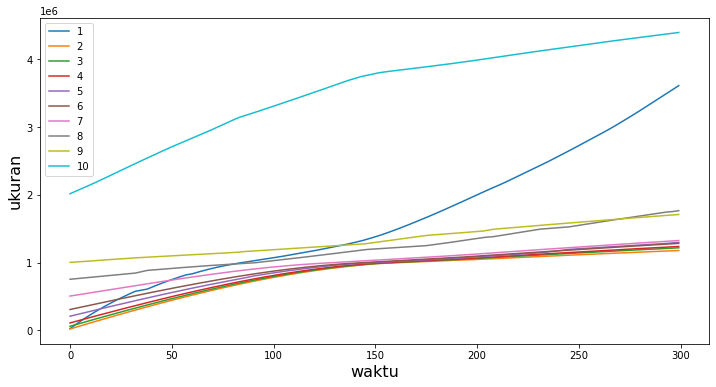

In [6]:
game.plot_size()

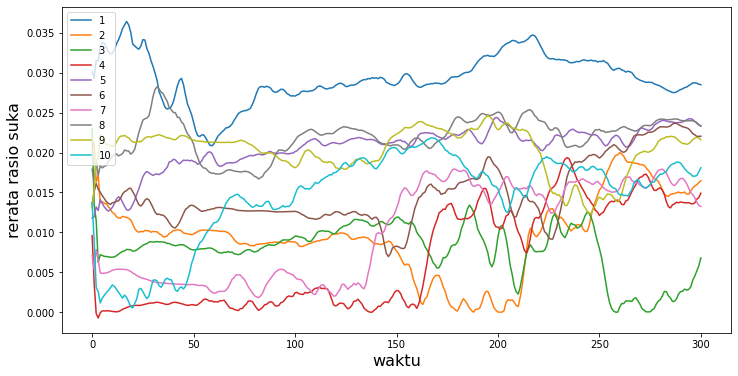

In [7]:
game.plot_lr()

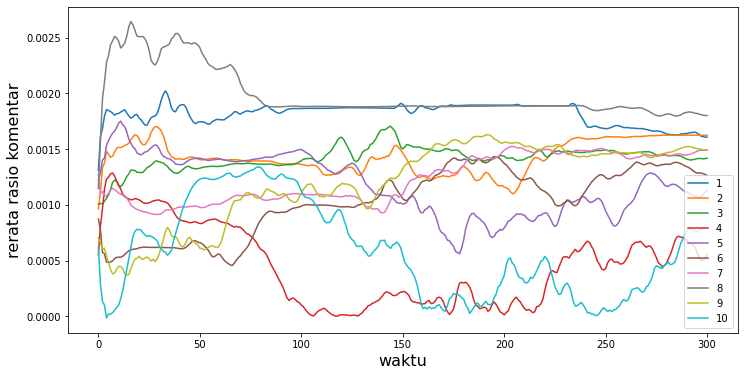

In [8]:
game.plot_cr()

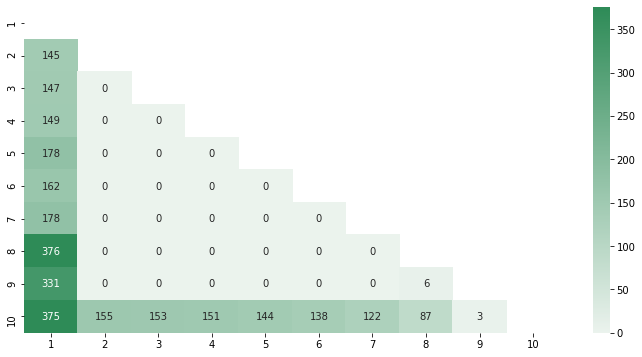

In [9]:
game.plot_action()